# MIMIC-III NLP

This notebook demonstrates how to apply natural language processing (NLP) to clinical notes from the MIMIC-III dataset. It covers:

- Named Entity Recognition (NER) using spaCy and scispaCy
- Comparing spaCy vs. scispaCy outputs
- Training Word2Vec embeddings on medical text
- Visualizing word embeddings using t-SNE
- Using ClinicalBERT embeddings for clinical text (this is for bonus points)

All examples use medical notes focused on subarachnoid hemorrhage.
Downloaded froom MIMIC-III physioncare database to my local as `data/mimiciii_notes_nonevents.csv`.


In [4]:
# 1. Load Data from noteevents.csv
# Load CSV - downloaded froom MIMIC-III physioncare database to my local
# We simulate a few medical discharge summaries from MIMIC-III's noteevents.csv file

import pandas as pd

# Load CSV - downloaded froom MIMIC-III physioncare database to my local
noteevents_df = pd.read_csv("data/mimiciii_notes_nonevents.csv")

print(f"Total notes loaded: {len(noteevents_df)}")

# Filter to DISCHARGE_SUMMARY
notes_df = noteevents_df[noteevents_df["CATEGORY"] == "Discharge summary"]

print(f"Number of discharge summaries: {len(notes_df)}")
# Keep only the TEXT column for NLP
notes_df = notes_df[["TEXT"]].dropna()
print(f"Shape of final DataFrame: {notes_df.shape}")


# print discharge summary text for the first note
print(f"Discharge sumary: {notes_df["TEXT"].iloc[0]}")

Total notes loaded: 5415
Number of discharge summaries: 154
Shape of final DataFrame: (154, 1)
Discharge sumary: Admission Date:  [**2166-1-19**]              Discharge Date:   [**2166-1-22**]

Date of Birth:  [**2140-7-1**]             Sex:   M

Service: SURGERY

Allergies:
Patient recorded as having No Known Allergies to Drugs

Attending:[**First Name3 (LF) 2534**]
Chief Complaint:
s/p Motor vehicle crash

Major Surgical or Invasive Procedure:
[**2166-1-21**] Closed reduction of left mandible fracture; wiring of
jaws

History of Present Illness:
25M driver s/p high-speed motor vehicle crash (car vs tree),
+seatbelt, +airbag, initially unresponsive for 3-4min on scene
but GCS14 at OSH; agitated/combative upon arrival to [**Hospital1 18**].

Past Medical History:
Undescended testicle, inguinal hernias
.
PSH: Bilateral hernia repair as infant; Right cryptorchidism s/p
removal and prosthesis placement; recurrent hernia repair at age
19


Family History:
Noncontributory

Pertinent Results

In [5]:
# 2. SpaCy Entity Extraction
# extracted general-purpose entities with the small English SpaCy model.
import spacy

# Load spaCy English model
nlp_spacy = spacy.load("en_core_web_sm")

text = notes_df["TEXT"].iloc[0]
doc_spacy = nlp_spacy(text)

print("\nEntities detected by SpaCy model:")
for ent in doc_spacy.ents:
    print(f"{ent.text} --> {ent.label_}")

# This extracts entities like names, dates, diagnoses, etc.



Entities detected by SpaCy model:
2166-1-19 --> DATE
2166-1-22 --> DATE
Date of Birth:   --> WORK_OF_ART
2140-7-1 --> DATE
No Known Allergies to Drugs --> ORG
2534 --> DATE
s/p Motor --> ORG
2166-1-21 --> DATE
History of Present Illness --> WORK_OF_ART
25 --> CARDINAL
3-4min --> CARDINAL
18 --> CARDINAL
PSH --> ORG
hernia --> GPE
19 --> CARDINAL
Family History --> PERSON
2166-1-19 --> DATE
CL--100 TCO2-22 --> PERSON
2166-1-19 --> DATE
UREA --> ORG
N-15 --> PRODUCT
2166-1-19 --> DATE
2166-1-19 --> DATE
HCT-41.3 --> ORG
2166-1-19 --> DATE
2166-1-19 --> DATE
2166-1-20 --> DATE
un --> ORG
TMJ --> ORG
2166-1-20 --> DATE
septum --> GPE
one day --> DATE
2166-1-20 --> DATE
TWO --> CARDINAL
VIEWS --> ORG
Linear --> ORG
2166-1-20 --> DATE
TWO --> CARDINAL
2 --> CARDINAL
VWS --> ORG
2166-1-19 --> DATE
fx --> ORG
TMJ --> ORG
2166-1-19 --> DATE
TMJ --> ORG
max --> PERSON
2166-1-19 --> DATE
7th --> ORDINAL
5 --> CARDINAL
4 cm --> QUANTITY
clin --> PERSON
the Trauma Service --> ORG
OMFS --> ORG
Deni

In [10]:
import spacy

nlp = spacy.load("en_core_sci_sm")

text = "Patient has subarachnoid hemorrhage and underwent coil embolization."

doc = nlp(text)

for ent in doc.ents:
    print(ent.text, ent.label_)


Patient ENTITY
subarachnoid hemorrhage ENTITY
coil ENTITY
embolization ENTITY


In [11]:
# 4. Train Word2Vec Embeddings
# Word2Vec learns word embeddings from the corpus of discharge summaries.
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

# Tokenize all notes
tokenized_notes = [simple_preprocess(text) for text in notes_df["TEXT"]]

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_notes,
    vector_size=50,
    window=5,
    min_count=1,
    workers=4,
    epochs=50
)

# Example: find similar words
print("\nSimilar words to 'hemorrhage':")
print(w2v_model.wv.most_similar("hemorrhage", topn=5))

# Word2Vec learns semantic similarities between words
# e.g. "hemorrhage" may be close to "rupture", "bleeding", etc.



Similar words to 'hemorrhage':
[('subarachnoid', 0.7088664174079895), ('frontal', 0.6838110685348511), ('extent', 0.6494568586349487), ('caudate', 0.6353552937507629), ('interval', 0.6264959573745728)]


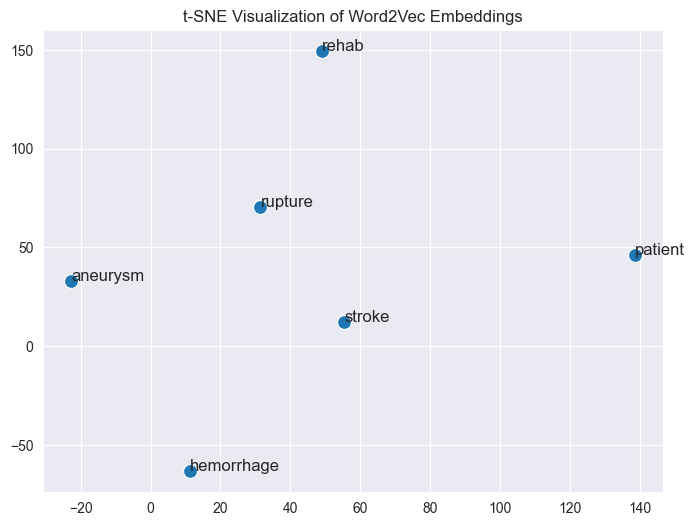

In [12]:
# 5. Visualize with t-SNE
# t-SNE visualizes high-dimensional word vectors in 2D space.
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Pick some medical words of interest
words_of_interest = ["hemorrhage", "aneurysm", "patient", "coiling", "rupture", "stroke", "rehab"]

vectors = []
filtered_words = []
for word in words_of_interest:
    if word in w2v_model.wv:
        vectors.append(w2v_model.wv[word])
        filtered_words.append(word)

vectors = np.array(vectors)

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=3, learning_rate=100)
tsne_results = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], s=100)

for i, word in enumerate(filtered_words):
    plt.text(tsne_results[i,0]+0.05, tsne_results[i,1]+0.05, word, fontsize=12)


plt.title("t-SNE Visualization of Word2Vec Embeddings")
plt.show()

# t-SNE projects high-dimensional word vectors into 2D for visualization.
# This helps us see clusters of medically related terms.


In [ ]:
# 6. Bonus - ClinicalBERT Embeddings
# ClinicalBERT is a BERT model pre-trained on clinical text.
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

inputs = tokenizer(
    sample_text,
    return_tensors="pt",
    truncation=True,
    max_length=512
)

with torch.no_grad():
    outputs = model(**inputs)

# CLS embedding
cls_embedding = outputs.last_hidden_state[:,0,:].squeeze()

print("\nClinicalBERT CLS embedding shape:", cls_embedding.shape)

# ClinicalBERT produces dense embeddings useful for clinical tasks.
# The CLS token embedding summarizes the input text's meaning.

